In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x, y):
    input_data = torch.cat((x, y), -1)
    output = torch.tanh(self.input_layer(input_data))
    for layer in self.hidden_layers:
      output = layer(output)
    final_output = self.output_layer(output)
    output1, output2 = torch.split(final_output, 1, dim=1)
    return output1, output2

In [ ]:
##Defining the Continuity Equation
def continuity_equation(u, v, x, y):
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, torch.ones_like(v), create_graph=True)[0]
    return u_x + v_y

In [ ]:
##Defining the X momentum Equation
def Xmomentum_equation(u, v, x, y, nu):
    usquare_x = torch.autograd.grad(u**2, x, torch.ones_like(u), create_graph=True)[0]
    uv_y = torch.autograd.grad(u*v, y, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u), create_graph=True)[0]
    return usquare_x + uv_y - nu*u_yy

In [ ]:
## Initialization of PINN and constants
torch.manual_seed(69)
pinn = PINN(2,40,2,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0002)
u0 = 1
nu = 0.002

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 41).view(-1, 1)
y1 = torch.linspace(0, 0.2, 41).view(-1, 1)
x1 = x1.view(-1)
y1 = y1.view(-1)
x_train1, y_train1 = torch.meshgrid(x1, y1)
x_train1 = x_train1.reshape(1681, 1).requires_grad_(True)
y_train1 = y_train1.reshape(1681, 1).requires_grad_(True)

In [ ]:
## y = 0 Boundary condition training data
x2 = torch.linspace(0, 1, 41).view(-1, 1)
y2 = torch.tensor(0.)
x2 = x2.view(-1)
y2 = y2.view(-1)
x_train2, y_train2 = torch.meshgrid(x2, y2)
x_train_y0 = x_train2.reshape(41, 1).requires_grad_(True)
y_train_y0 = y_train2.reshape(41, 1).requires_grad_(True)
u_train_y0 = 0
v_train_y0 = 0

In [ ]:
## y = 1 Boundary condition training data
x3 = torch.linspace(0, 1, 41).view(-1, 1)
y3 = torch.tensor(0.2)
x3 = x3.view(-1)
y3 = y3.view(-1)
x_train3, y_train3 = torch.meshgrid(x3, y3)
x_train_y1 = x_train3.reshape(41, 1).requires_grad_(True)
y_train_y1 = y_train3.reshape(41, 1).requires_grad_(True)
u_train_y1 = u0
v_train_y1_y = 0

In [ ]:
## x = 0 Boundary condition training data
y4 = torch.linspace(0, 0.2, 41).view(-1, 1)
x4 = torch.tensor(0.)
x4 = x4.view(-1)
y4 = y4.view(-1)
x_train4, y_train4 = torch.meshgrid(x4, y4)
x_train_x0 = x_train4.reshape(41, 1).requires_grad_(True)
y_train_x0 = y_train4.reshape(41, 1).requires_grad_(True)
u_train_x0 = u0
v_train_x0 = 0

In [ ]:
## Training Loop
epochs = 25000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  ## pde residual losses for continuity equation, momentum equation, and energy equation
  u_pred, v_pred = pinn(x_train1, y_train1)
  pde_loss1 = continuity_equation(u_pred, v_pred, x_train1, y_train1).pow(2).mean()
  pde_loss2 = Xmomentum_equation(u_pred, v_pred, x_train1, y_train1, nu).pow(2).mean()
  pde_loss = pde_loss1 + pde_loss2

  ## Boundary condition losses for for boundary y = 0
  u_pred_y0, v_pred_y0 = pinn(x_train_y0, y_train_y0)
  boundary_condition_loss_y0 = (u_pred_y0 - u_train_y0).pow(2).mean() + (v_pred_y0 - v_train_y0).pow(2).mean()

  ## Boundary condition losses for for boundary y = 0.2
  u_pred_y1, v_pred_y1 = pinn(x_train_y1, y_train_y1)
  v_pred_y1_y = torch.autograd.grad(v_pred_y1, y_train_y1, torch.ones_like(v_pred_y1), create_graph=True)[0]
  boundary_condition_loss_y1 = (u_pred_y1 - u_train_y1).pow(2).mean() + (v_pred_y1_y - v_train_y1_y).pow(2).mean()

  ## Boundary condition losses for for boundary x = 0
  u_pred_x0, v_pred_x0 = pinn(x_train_x0, y_train_x0)
  boundary_condition_loss_x0 = (u_pred_x0 - u_train_x0).pow(2).mean() + (v_pred_x0 - v_train_x0).pow(2).mean()

  p1 = 1
  boundary_condition_loss = boundary_condition_loss_y0 + boundary_condition_loss_y1 + boundary_condition_loss_x0
  total_loss = pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 2500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/25000, Total Loss: 2.07017183303833, pde Loss: 6.650308392863735e-08, Boundary Loss: 2.07017183303833
Epoch 2500/25000, Total Loss: 0.01879693940281868, pde Loss: 0.0008547298493795097, Boundary Loss: 0.017942208796739578
Epoch 5000/25000, Total Loss: 0.016605252400040627, pde Loss: 0.00030274916207417846, Boundary Loss: 0.016302503645420074
Epoch 7500/25000, Total Loss: 0.016576800495386124, pde Loss: 0.0005710285622626543, Boundary Loss: 0.01600577123463154
Epoch 10000/25000, Total Loss: 0.015987927094101906, pde Loss: 0.0003030432853847742, Boundary Loss: 0.015684884041547775
Epoch 12500/25000, Total Loss: 0.016444740816950798, pde Loss: 0.0009259670041501522, Boundary Loss: 0.015518773347139359
Epoch 15000/25000, Total Loss: 0.015985962003469467, pde Loss: 0.0007286862237378955, Boundary Loss: 0.015257276594638824
Epoch 17500/25000, Total Loss: 0.015407947823405266, pde Loss: 0.00034364350722171366, Boundary Loss: 0.015064304694533348
Epoch 20000/25000, Total Loss: 0.015210

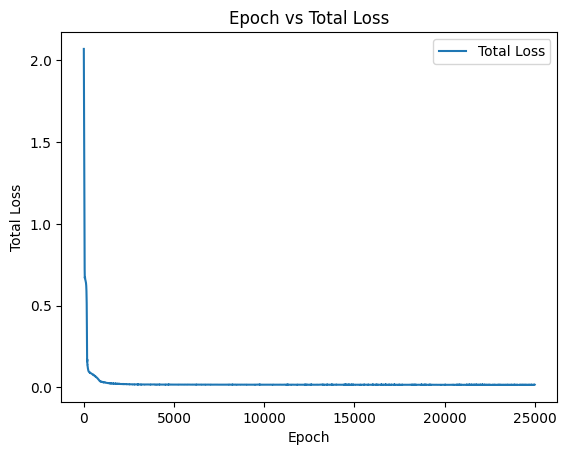

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    x_plot = torch.linspace(0, 1, 41)
    y_plot = torch.linspace(0, 0.2, 41)
    X, Y = torch.meshgrid(x_plot, y_plot)
    xy_combined = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
    u_pred_plot, v_pred_plot = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

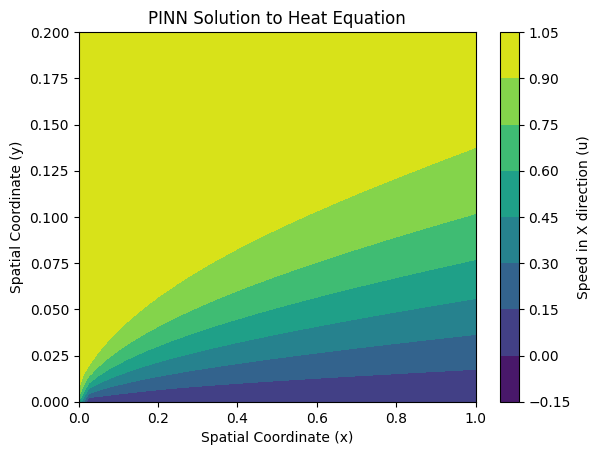

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), u_pred_plot.reshape(X.shape), cmap='viridis')
plt.colorbar(contour, label='Speed in X direction (u)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Heat Equation')
plt.show()

In [ ]:
## 2D contour plot
# plt.figure()
# contour = plt.contourf(X.numpy(), Y.numpy(), v_pred_plot.reshape(X.shape), cmap='viridis')
# plt.colorbar(contour, label='Speed in Y direction (v)')
# plt.xlabel('Spatial Coordinate (x)')
# plt.ylabel('Spatial Coordinate (y)')
# plt.title('PINN Solution to Heat Equation')
# plt.show()

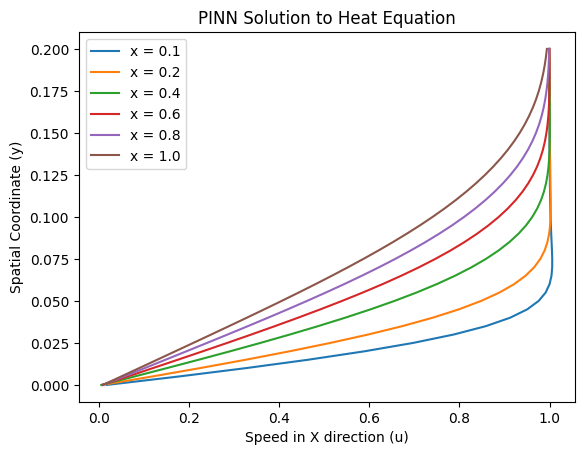

In [ ]:
with torch.no_grad():
    y_plot2 = torch.linspace(0, 0.2, 41)
    x_points = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

    plt.figure()

    for x_point in x_points:
        x_plot2 = torch.ones_like(y_plot2) * x_point
        xy_combined = torch.cat([x_plot2.reshape(-1, 1), y_plot2.reshape(-1, 1)], dim=1)

        u_pred_plot2, _ = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1))

        plt.plot(u_pred_plot2, y_plot2.numpy(), label=f'x = {x_point}')

    plt.xlabel('Speed in X direction (u)')
    plt.ylabel('Spatial Coordinate (y)')
    plt.title('PINN Solution to Heat Equation')
    plt.legend()
    plt.show()

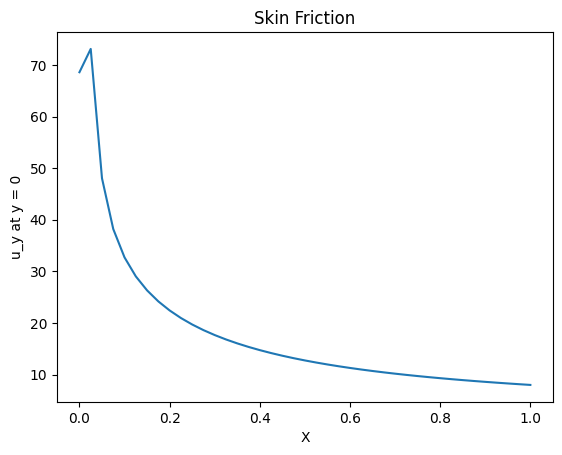

In [ ]:
x_plot3 = torch.linspace(0, 1, 41)
y_plot3 = torch.linspace(0, 0.2, 41)
X3, Y3 = torch.meshgrid(x_plot3, y_plot3)
Y3 = Y3.requires_grad_(True)
xy3_combined = torch.cat([X3.reshape(-1, 1), Y3.reshape(-1, 1)], dim=1)
u_pred_plot3, v_pred_plot3 = pinn(xy3_combined[:, 0].unsqueeze(1), xy3_combined[:, 1].unsqueeze(1))
u_pred_plot3 = u_pred_plot3.reshape(41,41)
u_pred_plot3_y = torch.autograd.grad(u_pred_plot3, Y3, torch.ones_like(u_pred_plot3), create_graph=True)[0]
u_pred_plot3_y = u_pred_plot3_y[:, 0]
plt.plot(x_plot3.detach().numpy(), u_pred_plot3_y.detach().numpy())
plt.xlabel('X')
plt.ylabel('u_y at y = 0')
plt.title('Skin Friction')
plt.show()

In [ ]:
## Actual training data for Inverse PINN
x_test = torch.tensor([0.1, 0.2, 0.4, 0.6, 0.8])
y_test = torch.tensor([0.02, 0.06, 0.08, 0.12, 0.16, 0.2])
x = x_test.requires_grad_(True).reshape(5, 1)
y = y_test.requires_grad_(True).reshape(6, 1)
x = x.view(-1)
y = y.view(-1)
x_train, y_train = torch.meshgrid(x, y)
x_train = x_train.reshape(30, 1).requires_grad_(True)
y_train = y_train.reshape(30, 1).requires_grad_(True)
u_train_actual, v_train_actual = pinn(x_train,y_train)
u_train_actual = u_train_actual.detach().numpy()
v_train_actual = v_train_actual.detach().numpy()
## Adding Gaussian noise to the Temperature data
mean = 0
std_dev = 0.01
gaussian_noise = numpy.random.normal(mean, std_dev, u_train_actual.shape)
u_noise_ = u_train_actual + gaussian_noise
u_noise = torch.tensor(u_noise_)
u_train_actual = u_noise.requires_grad_(True)
v_noise_ = v_train_actual + gaussian_noise
v_noise = torch.tensor(v_noise_)
v_train_actual = v_noise.requires_grad_(True)

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 41).view(-1, 1)
y1 = torch.linspace(0, 0.2, 41).view(-1, 1)
x1 = x1.view(-1)
y1 = y1.view(-1)
x_train1, y_train1 = torch.meshgrid(x1, y1)
x_train1 = x_train1.reshape(1681, 1).requires_grad_(True)
y_train1 = y_train1.reshape(1681, 1).requires_grad_(True)

In [ ]:
## y = 0 Boundary condition training data
x2 = torch.linspace(0, 1, 41).view(-1, 1)
y2 = torch.tensor(0.)
x2 = x2.view(-1)
y2 = y2.view(-1)
x_train2, y_train2 = torch.meshgrid(x2, y2)
x_train_y0 = x_train2.reshape(41, 1).requires_grad_(True)
y_train_y0 = y_train2.reshape(41, 1).requires_grad_(True)
u_train_y0 = 0
v_train_y0 = 0

In [ ]:
## y = 1 Boundary condition training data
x3 = torch.linspace(0, 1, 41).view(-1, 1)
y3 = torch.tensor(0.2)
x3 = x3.view(-1)
y3 = y3.view(-1)
x_train3, y_train3 = torch.meshgrid(x3, y3)
x_train_y1 = x_train3.reshape(41, 1).requires_grad_(True)
y_train_y1 = y_train3.reshape(41, 1).requires_grad_(True)
u_train_y1 = u0
v_train_y1_y = 0

In [ ]:
## x = 0 Boundary condition training data
y4 = torch.linspace(0, 0.2, 41).view(-1, 1)
x4 = torch.tensor(0.)
x4 = x4.view(-1)
y4 = y4.view(-1)
x_train4, y_train4 = torch.meshgrid(x4, y4)
x_train_x0 = x_train4.reshape(41, 1).requires_grad_(True)
y_train_x0 = y_train4.reshape(41, 1).requires_grad_(True)
u_train_x0 = u0
v_train_x0 = 0

In [ ]:
## Initialization of Inverse PINN
nu = torch.tensor([0.0005], requires_grad=True)
torch.manual_seed(68)
pinn2 = PINN(2,40,2,10)
parameters = [
    {'params': pinn2.parameters(), 'lr': 0.0002},
    {'params': [nu], 'lr': 0.00001}
]
optimizer = torch.optim.Adam(parameters)

In [ ]:
## Training Loop
epochs = 25000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  u_pred_actual, v_pred_actual = pinn2(x_train,y_train)
  Actual_loss = (u_pred_actual - u_train_actual).pow(2).mean() + (v_pred_actual - v_train_actual).pow(2).mean()

  ## pde residual losses for continuity equation, momentum equation, and energy equation
  u_pred, v_pred = pinn2(x_train1, y_train1)
  pde_loss1 = continuity_equation(u_pred, v_pred, x_train1, y_train1).pow(2).mean()
  pde_loss2 = Xmomentum_equation(u_pred, v_pred, x_train1, y_train1, nu).pow(2).mean()
  pde_loss = pde_loss1 + pde_loss2

  ## Boundary condition losses for for boundary y = 0
  u_pred_y0, v_pred_y0 = pinn2(x_train_y0, y_train_y0)
  boundary_condition_loss_y0 = (u_pred_y0 - u_train_y0).pow(2).mean() + (v_pred_y0 - v_train_y0).pow(2).mean()

  ## Boundary condition losses for for boundary y = 0.2
  u_pred_y1, v_pred_y1 = pinn2(x_train_y1, y_train_y1)
  v_pred_y1_y = torch.autograd.grad(v_pred_y1, y_train_y1, torch.ones_like(v_pred_y1), create_graph=True)[0]
  boundary_condition_loss_y1 = (u_pred_y1 - u_train_y1).pow(2).mean() + (v_pred_y1_y - v_train_y1_y).pow(2).mean()

  ## Boundary condition losses for for boundary x = 0
  u_pred_x0, v_pred_x0 = pinn2(x_train_x0, y_train_x0)
  boundary_condition_loss_x0 = (u_pred_x0 - u_train_x0).pow(2).mean() + (v_pred_x0 - v_train_x0).pow(2).mean()

  p1 = 1
  boundary_condition_loss = boundary_condition_loss_y0 + boundary_condition_loss_y1 + boundary_condition_loss_x0
  total_loss = Actual_loss + pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 2500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Nu: {nu.item()}")

Epoch 0/25000, Total Loss: 2.98014958262931, pde Loss: 8.882792599251843e-07, Boundary Loss: 2.1695549488067627, Nu: 0.0004966810229234397
Epoch 2500/25000, Total Loss: 0.03290821121344165, pde Loss: 0.0028719748370349407, Boundary Loss: 0.025122497230768204, Nu: 0.00020552484784275293
Epoch 5000/25000, Total Loss: 0.016497067976953293, pde Loss: 0.0006795278750360012, Boundary Loss: 0.014861561357975006, Nu: 0.0014045936986804008
Epoch 7500/25000, Total Loss: 0.015515062666563734, pde Loss: 0.0009585371008142829, Boundary Loss: 0.014026375487446785, Nu: 0.0012679294450208545
Epoch 10000/25000, Total Loss: 0.01451488211994276, pde Loss: 0.0002050289767794311, Boundary Loss: 0.013743896037340164, Nu: 0.0011776828905567527
Epoch 12500/25000, Total Loss: 0.014507518028404873, pde Loss: 0.00027119863079860806, Boundary Loss: 0.013644421473145485, Nu: 0.00114019017200917
Epoch 15000/25000, Total Loss: 0.014262356989392263, pde Loss: 0.000131242981296964, Boundary Loss: 0.013553395867347717,

In [ ]:
print(f"Nu: {nu.item()}")

Nu: 0.0010977908968925476
